## Exploratory Data Analysis on Seattle Terry Stops
This is a continuation of the project we started by preprocessing. As stated in the first part of this project, the "Preprocess file", the objectives of this project are:

* Determine if there is a relationship between Terry Stops and a subject's race
* Do the differences in races between the officer and the subject play a role in arrests?
* How do Terry Stops in Seattle compare to the circumstances around *Terry v. Ohio*?
* Determine the likelihood of an arrest occurring during a Terry Stop

In this part we will address the first three objectives and the fourth one will be covered in the third part of this project which is the modeling part.

## Loading the cleaned data

In [130]:
# Importing the relevant libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
%matplotlib inline

In [131]:
df = pd.read_csv('data/clean_Terry_stops_data.csv')
# df = df.drop('Unnamed:0', axis=1)
df.head()


,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_gender,officer_race,subject_perceived_race,...,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,reported_hour,same_race,same_gender
0,36_45,unassigned,20160000398323,208373,Offense Report,NaN,4852,M,Asian,White,...,L3,No,2016,11,63,N,Y,15,N,Y
1,18_25,unassigned,20180000227180,559146,Citation / Infraction,NaN,5472,M,Asian,Hispanic,...,F3,No,2018,6,54,N,N,0,N,Y
2,18_25,unassigned,20180000410091,498246,Offense Report,NaN,6081,M,White,White,...,B1,No,2018,11,56,N,Y,2,Y,Y
3,Unknown,unassigned,20160000001637,146742,Field Contact,NaN,6924,M,White,Not Specified,...,C1,No,2016,4,42,Y,N,1,N,N
4,46_55,unassigned,20150000006037,104477,Field Contact,NaN,6732,M,White,White,...,B2,No,2015,11,40,Y,N,2,Y,N


## Relationship between Terry Stops and Subject's Race
Here we will try to see if there is any relationship between the Terry Stops and the Subject's Race.

In [132]:
# Let us first check the stop resolutions
df.stop_resolution.value_counts()

stop_resolution
Field Contact               29173
Offense Report              15555
Arrest                      14592
Referred for Prosecution      717
Citation / Infraction         215
Name: count, dtype: int64

We are trying to see if race has any role to play in the Terry Stops. To do that let us calculate what the stop ratios are for each race in the dataset.

In [133]:
df.subject_perceived_race.value_counts()

subject_perceived_race
White                        29548
Black or African American    18119
Not Specified                 6108
Asian                         2070
Hispanic                      1666
Native American               1638
Multi-Racial                   796
Other                          307
Name: count, dtype: int64

In [134]:
# Calculating the stop ratios for each race in the dataset
df['subject_perceived_race'].value_counts(normalize=True)

subject_perceived_race
White                        0.490407
Black or African American    0.300720
Not Specified                0.101374
Asian                        0.034356
Hispanic                     0.027651
Native American              0.027186
Multi-Racial                 0.013211
Other                        0.005095
Name: proportion, dtype: float64

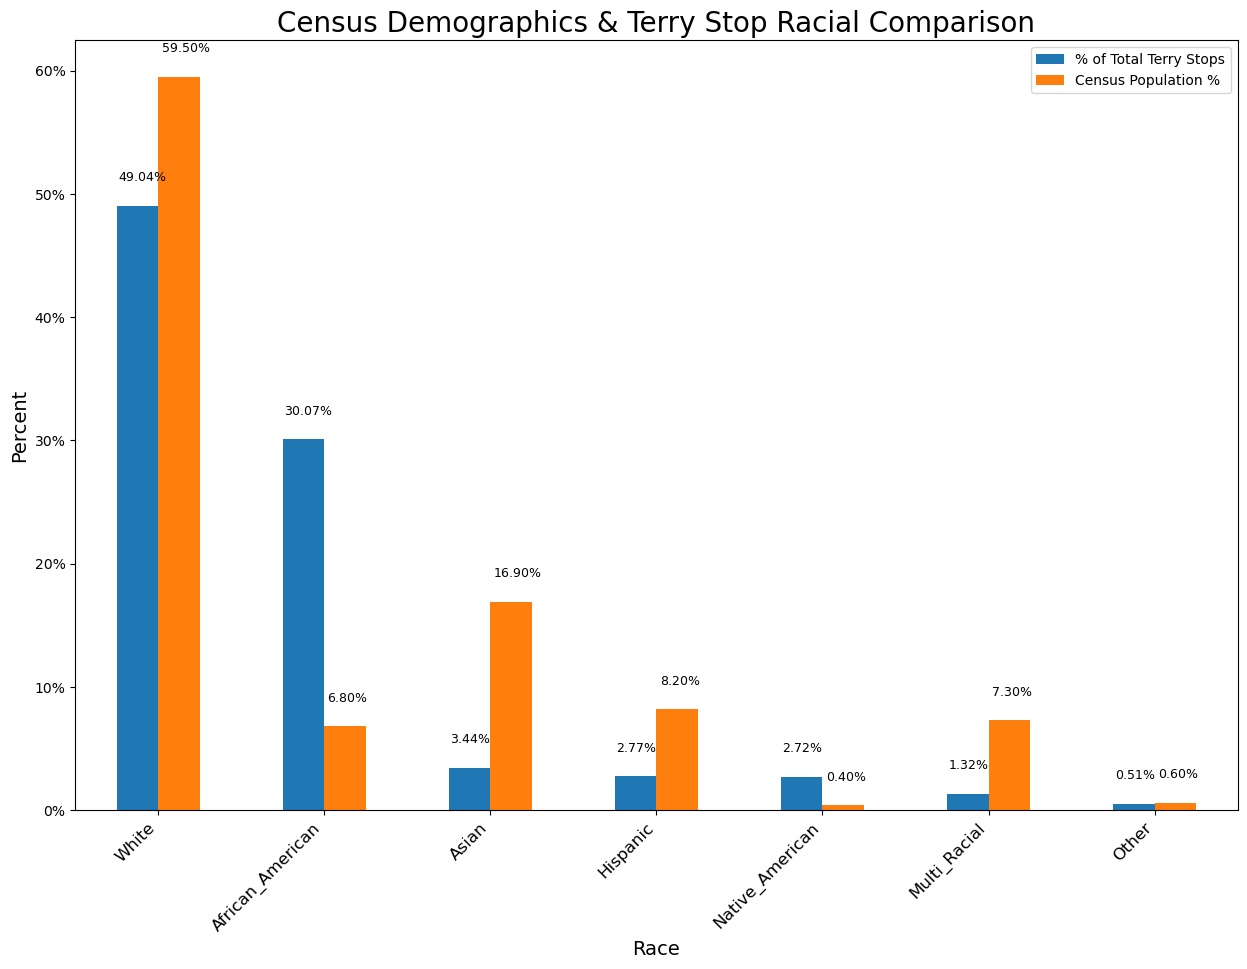

In [135]:
# Calculating the percentage of each race in the dataset  and assigning it to a new dataframe
races = ['White', 'African_American', 'Asian',
         'Hispanic', 'Native_American', 'Multi_Racial', 'Other']

stop_percents = [0.490407, 0.300720, 0.034356, 0.027651, 0.027186, 0.013211, 0.005095]
pop_percents = [0.595, 0.068, 0.169, 0.082, 0.004, 0.073, 0.006]

race_stop_ratios = pd.DataFrame({
    'race': races,
    'stop_percent': stop_percents,
    'population_percent': pop_percents}).set_index(['race'])

# plotting terry stop and census % data by race for comparison
ax = race_stop_ratios.plot(kind = 'bar', figsize = (15,10))

for i, v in enumerate(race_stop_ratios.stop_percent):
    ax.text(i-.24, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )

for i, v in enumerate(race_stop_ratios.population_percent):
    ax.text(i+.02, v+.02, '{:.2f}%'.format(100*v),fontsize = 9 )

plt.title('Census Demographics & Terry Stop Racial Comparison', fontsize = 20)
plt.xlabel('Race', fontsize = 14)
plt.ylabel('Percent', fontsize = 14)
plt.legend(loc = 'best', labels = ['% of Total Terry Stops', 'Census Population %'] )
plt.xticks(rotation = 45, ha='right', fontsize = 12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.show()


Ok we see here that even though the whites are the dominant race in Seattle, the proportion of the stop ratio vs the population is ok as is with all the other races except the native Americans and the African Americans. With the African Americans the result is worrisome. Even though they are only 6.8% of the population, the proportion of the stop ratio is 30%. This makes that race the most affected race by the Seattle Terry Stop.

In [136]:
# Checking the stop ratio vs the population ratio of each race
race_stop_ratios

,stop_percent,population_percent
race,,
White,0.490407,0.595
African_American,0.300720,0.068
Asian,0.034356,0.169
Hispanic,0.027651,0.082
Native_American,0.027186,0.004
Multi_Racial,0.013211,0.073
Other,0.005095,0.006


Text(0.5, 1.0, 'Proportion of People Stopped According to Respective Population')

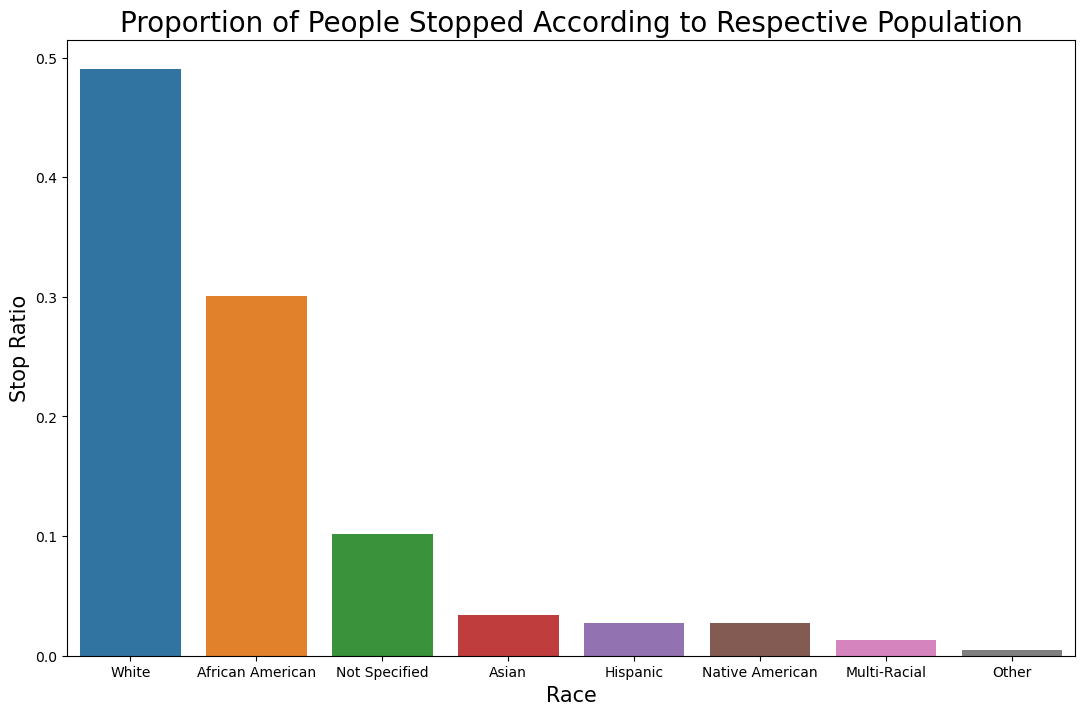

In [137]:
# let us plot this ratios
fig = plt.figure(figsize=(13,8))

ax = sns.barplot(stop_ratio_df)

ax.set_xlabel('Race', fontsize=15)
ax.set_ylabel('Stop Ratio', fontsize=15), 
ax.set_title('Proportion of People Stopped According' + ' to Respective Population', fontsize=20)

Ok so we see here that the highest stop ratio is for White with 49% and African American follows second with 30%. This may seem confusing compared to the graph above but note that this is as per the instances in the dataset. White being the largest race in the dataset, it is normal to see this result.

This requires to be checked. Let us do the frisk flag test to see what happens.

In [138]:
# Let create a dataframe called frisked to see the racial distributions of the frisk flag
frisked = df.copy()
frisked = frisked[frisked['frisk_flag'] == 'Y']

frisked.subject_perceived_race.value_counts()

subject_perceived_race
White                        6100
Black or African American    5142
Not Specified                1566
Asian                         572
Hispanic                      435
Native American               385
Multi-Racial                  181
Other                          74
Name: count, dtype: int64

As we can see it here as well the level of frisk instances between white and African American is almost parallel. Though the White race out numbers the African American race by a huge margin, the frisk instances are almost equal which can be an indication of the fact that there is a tendency towards racial bias.

In [139]:
# Calculate the total number of Terry Stops and the number of frisk stops for each race
# Assume 'race' is the column indicating race and 'frisk' indicates if a frisk occurred

total_stops = df.groupby('subject_perceived_race')['terry_stop_id'].count()
frisk_stops = df[df['frisk_flag'] == 'Y'].groupby('subject_perceived_race')['terry_stop_id'].count()

# Merge these two Series into a DataFrame for easier calculation
stop_data = pd.DataFrame({
    'total_stops': total_stops,
    'frisk_stops': frisk_stops})

# Calculate the frisk percentage
stop_data['frisk_percent'] = (stop_data['frisk_stops'] / stop_data['total_stops']) * 100
stop_data = stop_data.reset_index()
stop_data

,subject_perceived_race,total_stops,frisk_stops,frisk_percent
0,Asian,2070,572,27.632850
1,Black or African American,18119,5142,28.379050
2,Hispanic,1666,435,26.110444
3,Multi-Racial,796,181,22.738693
4,Native American,1638,385,23.504274
5,Not Specified,6108,1566,25.638507
6,Other,307,74,24.104235
7,White,29548,6100,20.644375


/var/folders/m7/31mld3hn46s_y1f05nhxt1_c0000gn/T/ipykernel_14760/3026284671.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=stop_data, x='subject_perceived_race', y='frisk_percent', palette='viridis', edgecolor='black')
/var/folders/m7/31mld3hn46s_y1f05nhxt1_c0000gn/T/ipykernel_14760/3026284671.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)


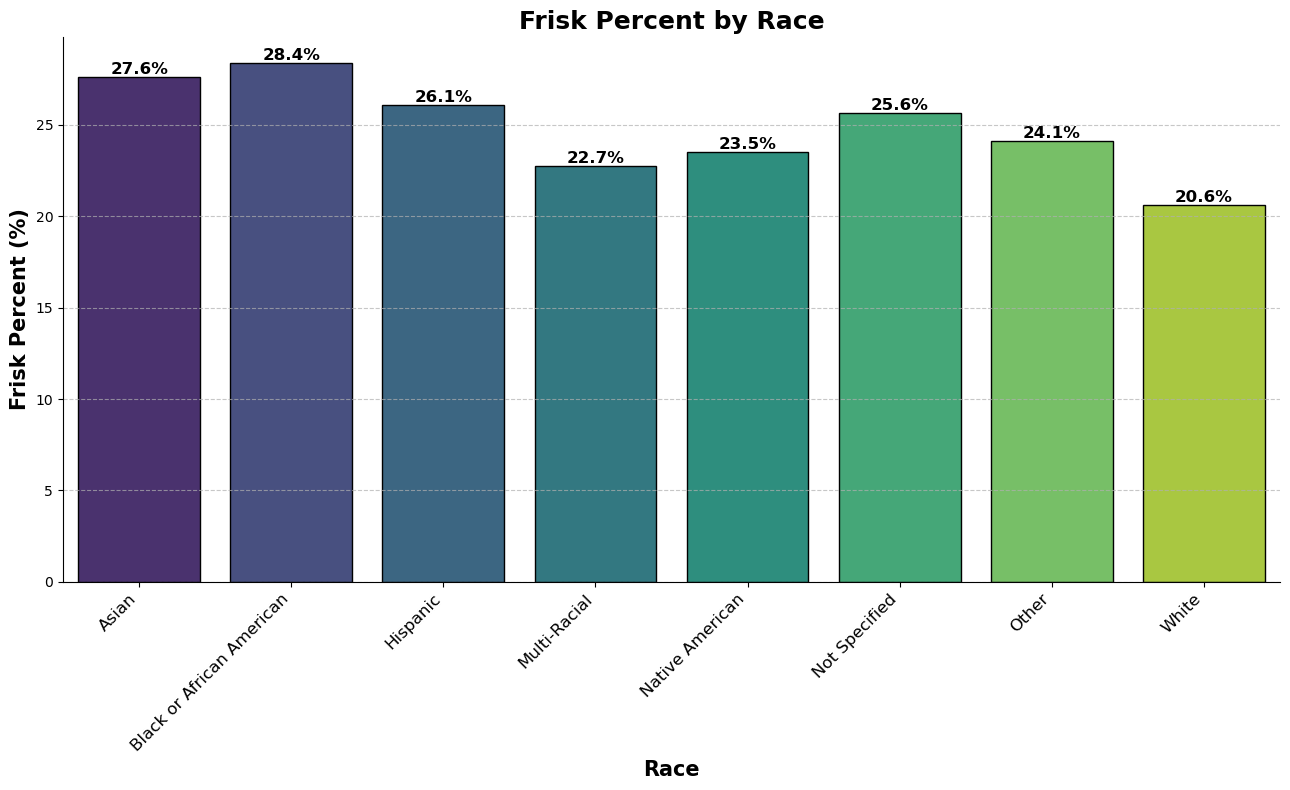

In [140]:
# Plotting stop data
fig = plt.figure(figsize=(13, 8))

# Use Seaborn to create the bar plot
ax = sns.barplot(data=stop_data, x='subject_perceived_race', y='frisk_percent', palette='viridis', edgecolor='black')

# Annotate bars with their values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=12, fontweight='bold', color='black')

# Set labels and title with enhanced styling
ax.set_xlabel('Race', fontsize=15, fontweight='bold')
ax.set_ylabel('Frisk Percent (%)', fontsize=15, fontweight='bold')
ax.set_title('Frisk Percent by Race', fontsize=18, fontweight='bold')

# Customize x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

# Customize gridlines and remove spines
ax.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()

# Display the plot
plt.tight_layout()
plt.show()

The higher frequency of frisk instances among the Black community during Terry stops in Seattle may stem from several interconnected factors:

* Historical and Systemic Bias: Long-standing racial biases and historical inequalities can influence policing practices, leading to disproportionate scrutiny of Black individuals.
* Policing Practices: Law enforcement may focus more on neighborhoods with higher crime rates, which can disproportionately affect racial minorities if those areas have higher minority populations.
* Socioeconomic Factors: Economic disparities, which often correlate with race, can result in more frequent police encounters in economically disadvantaged areas.
* Perceptions and Data: Biases in crime perception and the ways data are recorded and interpreted can affect how often stops and frisks are conducted among different racial groups.

Let us further check what happens with the arrest instances.

In [141]:
# Mapping the values of dif_race to 'Y' and 'N'
# df['same_race'] = df['same_race'].map({True: 'Y', False: 'N'})

# Relationship between Terry Stops and Arrests
arrests = df[['arrest_flag', 'frisk_flag', 'same_race']]

print(arrests.shape)
arrests.head()


(60252, 3)


,arrest_flag,frisk_flag,same_race
0,N,N,N
1,N,N,N
2,N,N,Y
3,N,N,N
4,N,N,Y


Ok now we'll make 2 datasets: One where officer and subject are the same race and another where they are not.

In [142]:
# Making datasets with the same officer and subject race and different officer and subject race
same_race = arrests[arrests['same_race'] == 'Y']
diff_race = arrests[arrests['same_race'] == 'N']

print(same_race.shape)
print(diff_race.shape)

(22989, 3)
(37263, 3)


Now lets separate our data into categories we can compare: Same Race Arrests and Frisks & Different Race Arrests and Frisks

In [143]:
# Separating the data into categories
same_arrest = 0
same_frisk = 0
for i in range(len(same_race)):
    if same_race.arrest_flag.iloc[i] == 'Y':
        same_arrest += 1
    if same_race.frisk_flag.iloc[i] == 'Y':
        same_frisk += 1
print(f'Same Race: Arrests = {same_arrest}, Frisk Searches = {same_frisk}')

diff_arrest = 0
diff_frisk = 0

for i in range(len(same_race)):
    if diff_race.arrest_flag.iloc[i] == 'Y':
        diff_arrest += 1
    if diff_race.frisk_flag.iloc[i] == 'Y':
        diff_frisk += 1
print(f'Different Race: Arrests = {diff_arrest}, Frisk Searches = {diff_frisk}')

Same Race: Arrests = 2251, Frisk Searches = 4764
Different Race: Arrests = 2649, Frisk Searches = 5967


Since these are based on different sized sets, we'll do what we did with races and calculate the ratio of these values to their respective dataset sizes

In [144]:
# Calculating the ratio
arrest_same_ratio = same_arrest/len(same_race)
frisk_same_ratio = same_frisk/len(same_race)
arrest_diff_ratio = diff_arrest/len(diff_race)
frisk_diff_ratio = diff_frisk/len(diff_race)

# Creating a dataframe for same race arrests and same race frisks
keys = ['Same Race: Arrests', 'Same Race: Frisk Searches']
vals = [arrest_same_ratio, frisk_same_ratio]

same_race = {}

for key in keys:
    for val in vals:
        same_race[key] = val
        vals.remove(val)
        break


same_race_df = pd.DataFrame(same_race, index=[0])
same_race_df 

,Same Race: Arrests,Same Race: Frisk Searches
0,0.097916,0.20723


In [145]:
# Creating a dataframe for different race arrests and different race frisks
keys = ['Different Race: Arrests', 'Different Race: Frisk Searches']
vals = [arrest_diff_ratio, frisk_diff_ratio]

diff_race = {}

for key in keys:
    for val in vals:
        diff_race[key] = val
        vals.remove(val)
        break

diff_race_df = pd.DataFrame(diff_race, index=[0])
diff_race_df 

,Different Race: Arrests,Different Race: Frisk Searches
0,0.071089,0.160132


In [146]:
# Combining the two dataframes
race_relations = pd.concat([same_race_df, diff_race_df], axis=1)
race_relations


,Same Race: Arrests,Same Race: Frisk Searches,Different Race: Arrests,Different Race: Frisk Searches
0,0.097916,0.20723,0.071089,0.160132


Text(0.5, 1.0, 'Officer & Subject Treatment: Same Race v. Different Race')

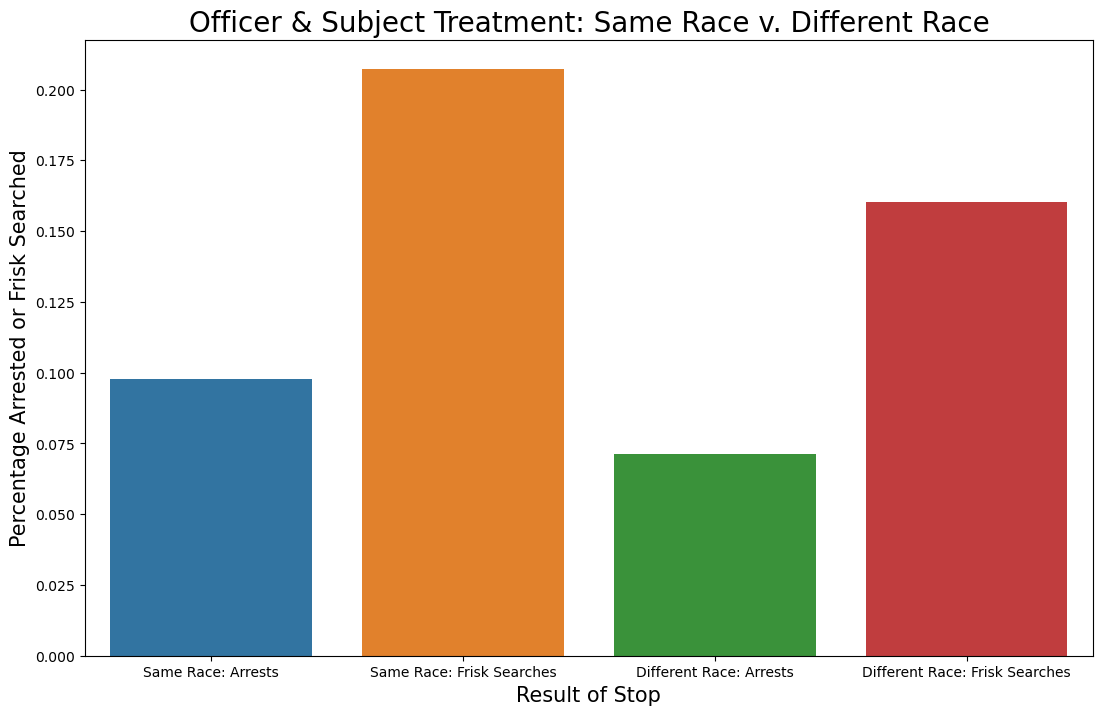

In [147]:
# Now let's plot this data
fig = plt.figure(figsize=(13,8))

ax = sns.barplot(race_relations)

ax.set_xlabel('Result of Stop', fontsize=15)
ax.set_ylabel('Percentage Arrested or Frisk Searched', fontsize=15),
ax.set_title('Officer & Subject Treatment: '+ 'Same Race v. Different Race', fontsize=20)


Ok so we see that there are more frisks and arrests among the same races, but fewer among different race. There could be a couple of reasons for this.  One is that an officer whose race is different is more hesitant and doesn't want to risk the possibility of their actions being considered racist.  Another explanation is that the officers in Seattle are assigned to beats where the local demographics match their own.

Let us do a comparison between the number of frisks and the number of arrests.

In [148]:
# Creating a subset of the dataset with the arrest and frisk features
arst_frsk = df[['arrest_flag', 'frisk_flag']]
print(arst_frsk.arrest_flag.value_counts())
print(arst_frsk.frisk_flag.value_counts())

arrest_flag
N    53752
Y     6500
Name: count, dtype: int64
frisk_flag
N    45797
Y    14455
Name: count, dtype: int64


Text(0.5, 1.0, 'Number of Terry Stop Arrests and/or Frisks')

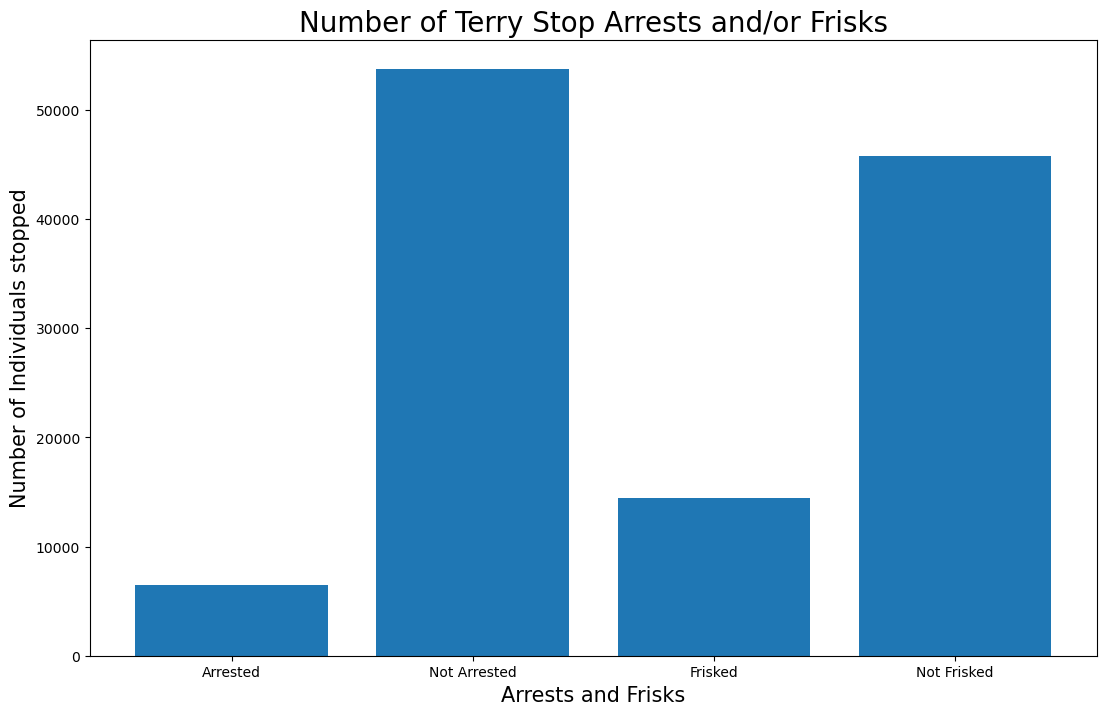

In [149]:
# Plotting the comparison
arrest_yes = 6500
arrest_no = 53752
frisk_yes = 14455
frisk_no = 45797

x = ['Arrested', 'Not Arrested', 'Frisked', 'Not Frisked']
y = [arrest_yes, arrest_no, frisk_yes, frisk_no]

fig = plt.figure(figsize=(13,8))

ax = sns.barplot()
ax.bar(x, y)
ax.set_xlabel('Arrests and Frisks', fontsize=15)
ax.set_ylabel('Number of Individuals stopped', fontsize=15),
ax.set_title('Number of Terry Stop Arrests and/or Frisks', fontsize=20)



It is interesting to see that there is a huge gap between the number of people frisked and the number of people arrested. This could sound like a faulty call by the officers frisking people without enough information which could mean violation of people's 4th amendment right. On the other hand it could mean a cautious approach by officers, focusing on immediate safety concerns without escalating to arrests unless justified. However, it's important to continuously review these practices to ensure they align with legal standards and community expectations.

To help us decide which one it is in this context, it is good to identify the common outcome of the stop resolutions.

Text(0.5, 1.0, 'Seattle Terry Stop Results')

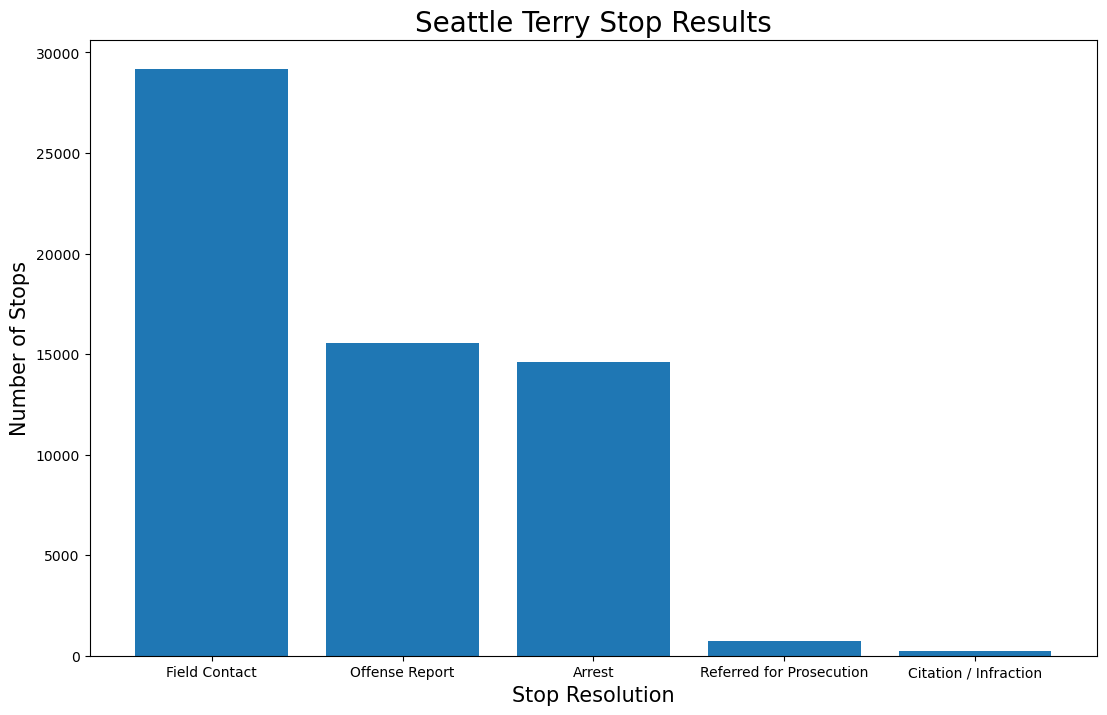

In [150]:
# Creating a comparison between the different values of the stop resolution
x = df['stop_resolution'].value_counts().index
y = df['stop_resolution'].value_counts()

# Plotting the comparison
fig = plt.figure(figsize=(13,8))

ax = sns.barplot()
ax.bar(x, y)
ax.set_xlabel('Stop Resolution', fontsize=15)
ax.set_ylabel('Number of Stops', fontsize=15)
ax.set_title('Seattle Terry Stop Results', fontsize=20)

The most common outcome of the Seattle Terry Stop resolution happens to be "Field Contact". While field contacts are generally less intrusive than formal stops, a high frequency should be assessed to ensure it aligns with the goals of the resolution, maintains community trust, and is in line with fair policing practices.
This result confirms that the numerous frisk instances are actually more of a preventive measures than violations of people's rights but extreme caution is necessary.

## Yearly Terry Stops pattern covering the duration time period in the dataset

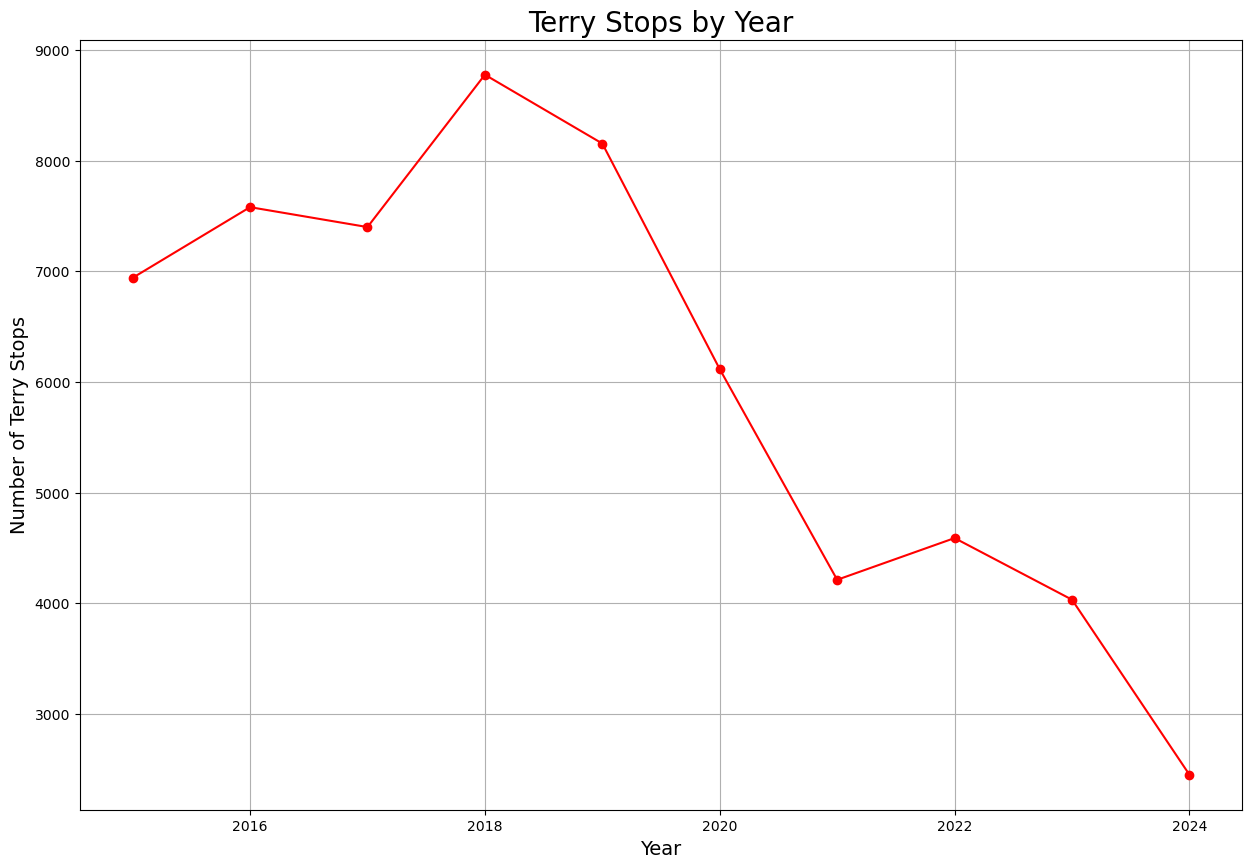

In [151]:
# Creating a new DataFrame with the year column and a count column
year_df = pd.DataFrame(df['incident_year'])
year_df['count'] = 1

# Group by 'incident_year' and sum the 'count' column
year_graph = year_df.groupby('incident_year', as_index=False)['count'].sum()

# Plot the number of Terry Stops by year
plt.figure(figsize=(15,10))
plt.plot(year_graph['incident_year'], year_graph['count'], color='red', marker='o')
plt.title('Terry Stops by Year', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Terry Stops', fontsize=14)
plt.grid(True)  # Enable grid for better readability

plt.show()

The spike in Terry Stops in Seattle in 2018 was a direct response to the surge in gun violence in the city. The Seattle Police Department's decision to increase stop-and-frisk activities was part of a broader strategy to address public safety concerns and reduce violent crime.

The drastic fall in Terry Stops in Seattle from 2019 to 2021 can be attributed to a combination of factors, including increased scrutiny and accountability due to police reform measures, the impact of protests and calls for reform (following the George Floyd incident), changes in crime trends, legal and community challenges, and operational shifts influenced by the pandemic. These factors collectively contributed to a reduction in the number of Terry Stops conducted by law enforcement during this period.

While the drop in Terry stop instances between 2023 and 2024 could reflect successful reforms, shifts in policing strategy, or changes in crime trends, among other factors. Understanding the specific reasons for the decline is crucial for evaluating its significance and ensuring that policing practices align with broader goals of fairness and effectiveness.

## Conclusion
1. The fact that Black individuals experience 30% of Terry stops and despite being only 6.8% of the population suggests a significant racial disparity in policing. This indicates potential biases in police practices and a need for comprehensive reforms to address these disparities and ensure fair treatment for all communities.
2. The data suggests that Black individuals, while experiencing fewer overall Terry stops compared to White individuals, are subject to frisks more frequently when stopped. This disparity could indicate potential racial bias or differing police practices that result in more invasive procedures for Black individuals. Addressing this issue involves examining policing practices, understanding the reasons behind the higher frisk rates, and implementing reforms to ensure fair and unbiased law enforcement.
3. A large gap between the number of people frisked and the number of arrests can have negative impacts on individuals, community relations, and policing effectiveness. It may lead to perceptions of unfairness, reduced trust in law enforcement, and potential legal and ethical concerns. Addressing this issue involves reviewing and potentially reforming stop-and-frisk practices, ensuring they are conducted fairly and effectively, and focusing on building trust and transparency with the community.
4. The prevalence of "Field Contact" as the most common outcome of Terry stops in Seattle indicates that many stops do not result in formal legal action but rather involve brief interactions with individuals. This trend highlights the role of field contacts in proactive policing and community engagement, while also raising questions about effectiveness, resource allocation, and community perceptions. Reviewing and refining practices related to field contacts can help ensure that these interactions are constructive and aligned with broader policing goals.
5. The decrease in Terry stop rates in Seattle compared to their initial introduction reflects a range of factors, including potential policy reforms, changes in policing strategies, public and community influence, shifts in crime trends, and evolving legal and ethical considerations. This trend indicates a move towards more balanced and thoughtful approaches to policing, with an emphasis on community relations and effectiveness. Understanding these changes helps ensure that policing practices continue to evolve in response to community needs and legal standards.